# **Video Captioning using CNN**

## Importing packages

In [ ]:
import os
import cv2
import math
import random
import numpy as np
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## Loading Dataset and Visualisation

In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2022-04-26 03:31:22--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  26.7MB/s    in 1m 59s  

2022-04-26 03:33:22 (25.9 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



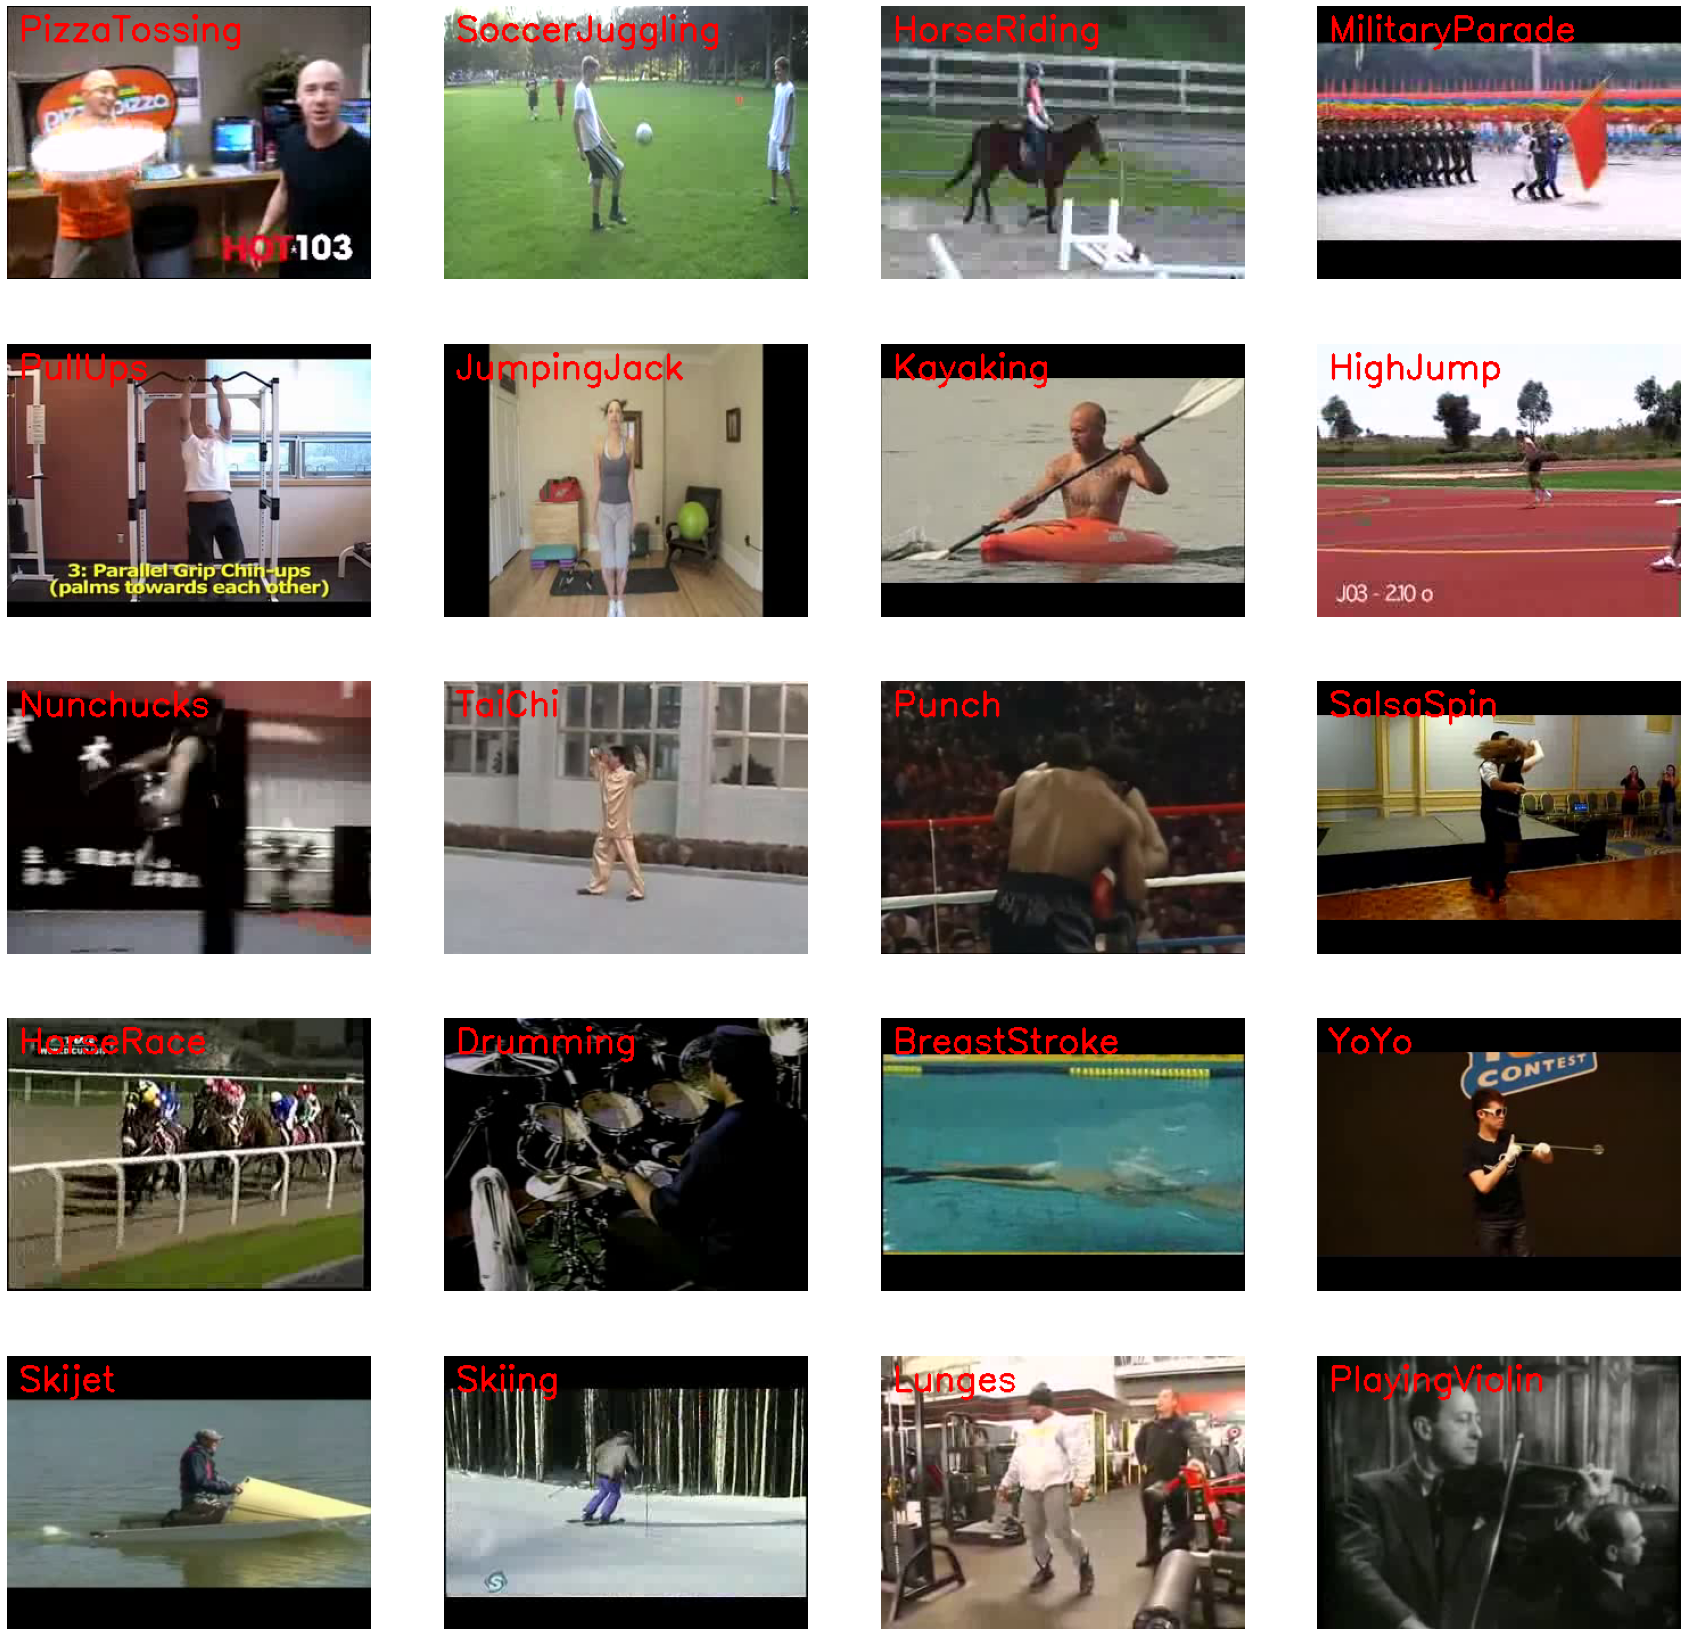

In [ ]:
 # Create a Matplotlib figure
plt.figure(figsize = (30, 30))

# Get Names of all classes in UCF50
all_classes_names = os.listdir('UCF50')

# Generate |a random sample of images each time the cell runs
random_range = random.sample(range(len(all_classes_names)), 20)

# Iterating through all the random samples
for counter, random_index in enumerate(random_range, 1):

    # Getting Class Name using Random Index
    selected_class_Name = all_classes_names[random_index]

    # Getting a list of all the video files present in a Class Directory
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    # Randomly selecting a video file
    selected_video_file_name = random.choice(video_files_names_list)

    # Reading the Video File Using the Video Capture
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # Converting the BGR Frame to RGB Frame 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Adding The Class Name Text on top of the Video Frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    # Assigning the Frame to a specific position of a subplot
    plt.subplot(5, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')

## Preprocessing

In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 8000

dataset_directory = "UCF50"
classes_list = ["Basketball", "JugglingBalls", "YoYo", "SoccerJuggling"]

model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: JugglingBalls
Extracting Data of Class: YoYo
Extracting Data of Class: SoccerJuggling


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

## Train-Test split

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

## Baseline Model

In [ ]:
def create_model():
   model = Sequential()

   model.add(Conv2D(filters = 64, kernel_size = (1, 1), activation = 'relu', input_shape = (image_height, image_width, 3)))
   model.add(MaxPooling2D(pool_size = (2, 2)))
   model.add(GlobalAveragePooling2D())
   model.add(Dense(256, activation = 'relu'))
   model.add(Dense(model_output_size, activation = 'softmax'))
   model.summary()
   return model

model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        256       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 17,924
Trainable params: 17,924
Non-traina

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
640/640 [==============================] - 17s 12ms/step - loss: 1.3783 - accuracy: 0.3055 - val_loss: 1.3708 - val_accuracy: 0.3371
Epoch 2/10
640/640 [==============================] - 8s 12ms/step - loss: 1.3655 - accuracy: 0.3802 - val_loss: 1.3578 - val_accuracy: 0.4053
Epoch 3/10
640/640 [==============================] - 7s 11ms/step - loss: 1.3525 - accuracy: 0.4062 - val_loss: 1.3438 - val_accuracy: 0.3973
Epoch 4/10
640/640 [==============================] - 8s 12ms/step - loss: 1.3382 - accuracy: 0.4189 - val_loss: 1.3297 - val_accuracy: 0.3934
Epoch 5/10
640/640 [==============================] - 8s 12ms/step - loss: 1.3236 - accuracy: 0.4174 - val_loss: 1.3138 - val_accuracy: 0.4291
Epoch 6/10
640/640 [==============================] - 7s 12ms/step - loss: 1.3088 - accuracy: 0.4235 - val_loss: 1.2995 - val_accuracy: 0.4262
Epoch 7/10
640/640 [==============================] - 7s 12ms/step - loss: 1.2944 - accuracy: 0.4308 - val_loss: 1.2859 - val_accuracy: 0.434

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 1s 6ms/step - loss: 1.2502 - accuracy: 0.4723


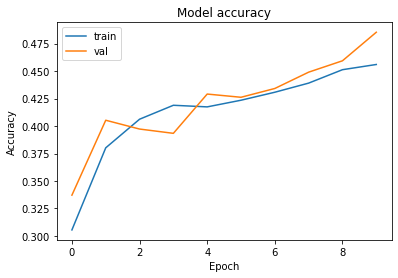

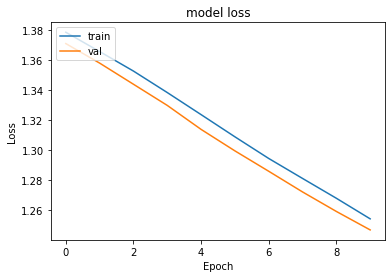

In [ ]:
def plot_history(history):
    """
    Plots the accuracy and the loss
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_history(model_training_history)

## Modified model

In [ ]:
def create_model():

    model = Sequential()
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    # Printing the models summary
    model.summary()

    return model


# Calling the create_model method
model = create_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 64)               0         
 (GlobalAveragePooling2D)                                        
                                                      

In [ ]:
# Adding loss, optimizer and metrics values to the model.
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='model.weights.best_10epochs.hdf5',
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=2)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs =10, validation_split = 0.2,  callbacks=[checkpoint])

Epoch 1/10
639/640 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.8868
Epoch 1: val_accuracy improved from -inf to 0.73828, saving model to model.weights.best_10epochs.hdf5
640/640 [==============================] - 25s 35ms/step - loss: 0.3179 - accuracy: 0.8869 - val_loss: 0.5458 - val_accuracy: 0.7383
Epoch 2/10
639/640 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9802
Epoch 2: val_accuracy improved from 0.73828 to 0.88379, saving model to model.weights.best_10epochs.hdf5
640/640 [==============================] - 21s 33ms/step - loss: 0.0700 - accuracy: 0.9802 - val_loss: 0.2650 - val_accuracy: 0.8838
Epoch 3/10
640/640 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9878
Epoch 3: val_accuracy did not improve from 0.88379
640/640 [==============================] - 22s 34ms/step - loss: 0.0434 - accuracy: 0.9878 - val_loss: 0.5114 - val_accuracy: 0.8357
Epoch 4/10
640/640 [==============================] - E

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

200/200 [==============================] - 2s 9ms/step - loss: 0.0166 - accuracy: 0.9967


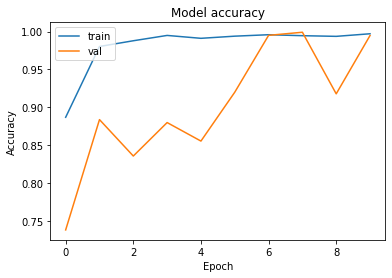

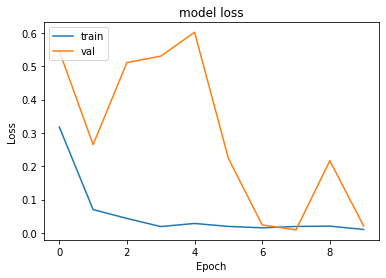

In [ ]:
plot_history(model_training_history)

## Better Methods



*   Using CNN with LSTMs
*   Using Pose Detection and LSTM
*   Using Optical Flow and CNN’s
*   Using SlowFast Networks
*   Using 3D CNN’s / Slow Fusion






### Prediction without Moving Average

In [ ]:
input_video_file_path = "/content/BB.mp4"

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)

        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# Setting sthe Window Size which will be used by the Rolling Average Proces
window_size = 1

# Constructing The Output YouTube Video Path
output_video_file_path = "/content/BB_Out.mp4"

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

### Prediction using moving average

In [ ]:
# Setting the Window Size which will be used by the Rolling Average Process
window_size = 25

# Constructing The Output YouTube Video Path
output_video_file_path = "/content/BB_Out_2.mp4"
# Calling the predict_on_live_video method to start the Prediction and Rolling Average Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)